README: updated: 
- reorganize time_property_modeling.ipynb into fundtion

In [5]:
import os
os.chdir('/Users/liyuan/desktop/SI699/codes')
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_squared_error

from ts_modeling_v2 import TsModeling
from reformat_data_by_day import Reformat_data
from time_feature_modeling import TimeFeatureModeling
from help import sample_data, get_rmse, get_predictions,extract_time_features

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from prop_modeling_v3 import PropModeling

In [6]:
def get_rmse(pred, true):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return rmse

In [7]:
class TimePropModeling():
    def __init__(self):
        pass

    def load_data(self):
        # load all data
        train = pd.read_csv('../expedia_data/train.csv')
        test = pd.read_csv('../expedia_data/test.csv')
        cols_train_only = [col for col in train.columns.unique().tolist() if col not in test.columns.unique().tolist()]
        train = train.drop(columns = cols_train_only)
        all_data = pd.concat([train, test], ignore_index=True)
        print('there are %d records in train and test data combined' % len(all_data))
        return all_data
    
    def modeling(self,all_data,prop_id):
        # get data by property_id
        prop_id_lst = all_data['prop_id'].unique().tolist()
        print('there are %d property id'%len(prop_id_lst))

        # get data by property id
        prop_data = all_data[all_data['prop_id'] == prop_id]
        print('property 116942 has %d records' % len(prop_data))

        # get daily property data
        tsm = TsModeling()
        prop_data = tsm.process_data_by_prop(prop_data)
        daily_price = prop_data[['price_usd']].resample('D').median()
        print('property has %d records by day'% len(daily_price))

        # fit ARIMA
        tsm.get_auto_correlation(daily_price)
        train, val, test = tsm.split_data(daily_price) # split X
        print('plot for ARIMA model ...')
        val_predictions, test_predictions = tsm.fit_ARIMA_model(daily_price.dropna(), 2,0,0)
    
        # fit regression
        daily_price = extract_time_features(daily_price)
        regression_y_pred_train, regression_y_pred_val, regression_y_pred_test = tsm.fit_regression_model(daily_price.dropna())
        
        # task: second-layer modeling (XGBoost)
        # has finished basic parameter tuning
        model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 25) 
        y_pred_train, y_pred_test = tsm.second_layer_modeling(model)
        
        # task: combine property modeling + time modeling
        # modify based on features_prop_update_v2.ipynb
        def prop_modeling(all_data, prop_id):
            pm = PropModeling()
            y_pred_train, y_pred_val, y_pred_test = pm.prop_modeling(all_data, prop_id)
            return y_pred_val, y_pred_test
        y_pred_train_prop, y_pred_test_prop = prop_modeling(all_data,prop_id)

        # reshape predictions from time modeling
        y_pred_train_ = y_pred_train.reshape(-1,1)
        y_pred_test_ = y_pred_test.reshape(-1,1)

        # reshape predictions from propery modeling
        print(y_pred_train_prop.shape)
        print(y_pred_test_prop.shape)
        y_pred_train_prop_ = y_pred_train_prop.reshape(-1,1)
        y_pred_test_prop_ = y_pred_test_prop.reshape(-1,1)

        # combine predictions results with my codes
        X_train = np.concatenate(( y_pred_train_prop_, y_pred_train_), axis=1)
        X_test = np.concatenate(( y_pred_test_prop_, y_pred_test_), axis=1)
        # get y_train, y_test
        y_train = tsm.val
        y_test = tsm.test
        
        # task: fit third-layer model
        # model = LinearRegression()
        # model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 20) 
        model = RandomForestRegressor()

        reg = model.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)
        # get rmse
        train_RMSE = get_rmse(y_pred_train ,y_train)
        test_RMSE = get_rmse(y_pred_test ,y_test)
        print('train rmse: %d'%train_RMSE)
        print('test rmse: %d'%test_RMSE)
        
        return y_pred_train, y_pred_test

there are 16540159 records in train and test data combined
there are 140821 property id
property 116942 has 7383 records


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)
/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:77: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  autocorrelation_plot(data)


property has 242 records by day


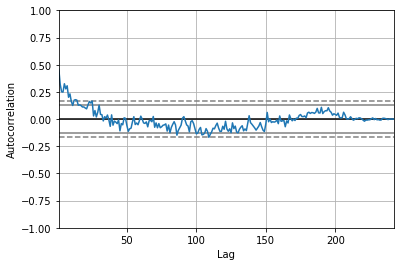

training size: 155
validation size: 38
test size: 48
plot for ARIMA model ...
training size: 155
validation size: 38
test size: 48


/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

RMSE: 19.743


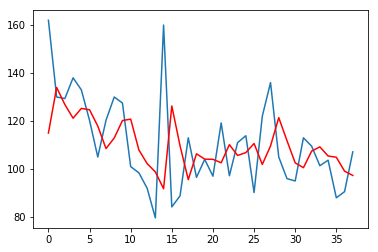

RMSE: 16.756


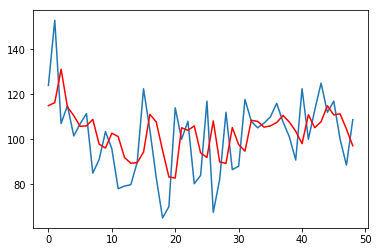

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

price data len: 242
242
variance of data: 357
training size: 155
validation size: 38
test size: 48
training RMSE: 16.352462388808384
valiation RMSE: 22.87300786282893
test RMSE: 20.36747232790119
(38, 1)
(49, 1)
(38, 1)
(49, 1)
y_train shape: (38, 1)
y_test shape: (49, 1)
train rmse: 18
test rmse: 17


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

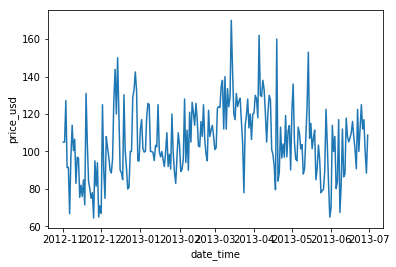

In [4]:
t = TimePropModeling()
all_data = t.load_data()
y_pred_train, y_pred_test = t.modeling(all_data,116942)

there are 140821 property id
property 116942 has 1635 records


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)
/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:77: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  autocorrelation_plot(data)


property has 242 records by day


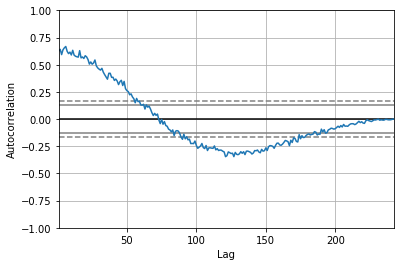

training size: 155
validation size: 38
test size: 48
plot for ARIMA model ...
training size: 155
validation size: 38
test size: 48


/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/leetcode/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this 

RMSE: 30.567


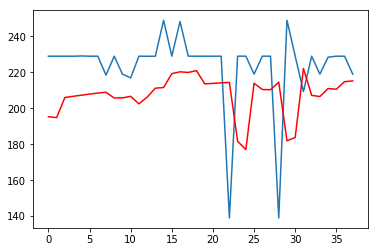

RMSE: 29.306


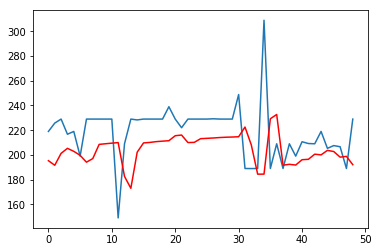

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

price data len: 242
242
variance of data: 2146
training size: 155
validation size: 38
test size: 48
training RMSE: 37.643942427158926
valiation RMSE: 83.92821961729362
test RMSE: 53.46784285103863
(38, 1)
(49, 1)
(38, 1)
(49, 1)
y_train shape: (38, 1)
y_test shape: (49, 1)
train rmse: 22
test rmse: 27
training size: 155
validation size: 38
test size: 48


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

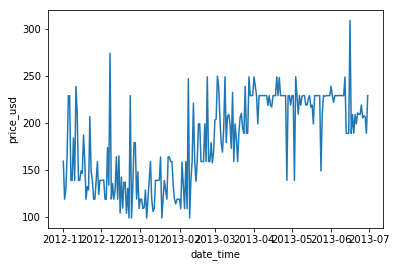

In [18]:
# TODO: feed into more prop_id
t.modeling(all_data,134232)